# Load Data

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
# Use the file upload widget
from google.colab import files
files.upload()  # Upload your kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beyzabal0","key":"91cff5f1980f29e22e2d53dcc5a1d50b"}'}

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!cp kaggle.json /root/.kaggle/

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c home-credit-credit-risk-model-stability

In [ ]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [ ]:
!unzip home-credit-credit-risk-model-stability.zip

Archive:  home-credit-credit-risk-model-stability.zip
  inflating: csv_files/test/test_applprev_1_0.csv  
  inflating: csv_files/test/test_applprev_1_1.csv  
  inflating: csv_files/test/test_applprev_1_2.csv  
  inflating: csv_files/test/test_applprev_2.csv  
  inflating: csv_files/test/test_base.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_3.csv  
  inflating: csv_files/test/test_credit_bureau_a_1_4.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_0.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_1.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_10.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_11.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_2.csv  
  inflating: csv_files/test/test_credit_bureau_a_2_3.csv  
  inflating: csv_files/test/test_credit_burea

In [ ]:
dataPath = "/content/"

In [ ]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [ ]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

# Join Tables & Feature Engineering

In [ ]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [ ]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [ ]:
data = data.to_pandas()
data['date_decision'] = pd.to_datetime(data['date_decision'])
print(f"Date range: {data['date_decision'].min()} to {data['date_decision'].max()}")
print(f"Week range: {data['WEEK_NUM'].min()} to {data['WEEK_NUM'].max()}")

Date range: 2019-01-01 00:00:00 to 2020-10-05 00:00:00
Week range: 0 to 91


In [ ]:
# Pre-COVID training, COVID validation/testing
covid_start = pd.Timestamp('2020-03-01')
mid_covid = pd.Timestamp('2020-07-01')

# Split data based on these dates
train_data = data[data['date_decision'] < covid_start]             # Pre-COVID (Jan 2019-Feb 2020)
valid_data = data[(data['date_decision'] >= covid_start) &
                  (data['date_decision'] < mid_covid)]            # Early COVID (Mar 2020-Jun 2020)
test_data = data[data['date_decision'] >= mid_covid]              # Later COVID (Jul 2020-Oct 2020)

# Print split information
print(f"Training (pre-COVID): {len(train_data)} samples ({train_data['date_decision'].min()} to {train_data['date_decision'].max()})")
print(f"Validation (early COVID): {len(valid_data)} samples ({valid_data['date_decision'].min()} to {valid_data['date_decision'].max()})")
print(f"Test (later COVID): {len(test_data)} samples ({test_data['date_decision'].min()} to {test_data['date_decision'].max()})")

Training (pre-COVID): 1232695 samples (2019-01-01 00:00:00 to 2020-02-29 00:00:00)
Validation (early COVID): 143724 samples (2020-03-01 00:00:00 to 2020-06-30 00:00:00)
Test (later COVID): 150240 samples (2020-07-01 00:00:00 to 2020-10-05 00:00:00)


In [ ]:
cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)
print(cols_pred)

base_train = train_data[["case_id", "WEEK_NUM","MONTH", "target"]]
y_train = train_data["target"]
X_train = train_data[cols_pred]

base_valid = valid_data[["case_id", "WEEK_NUM","MONTH", "target"]]
y_valid = valid_data["target"]
X_valid = valid_data[cols_pred]

base_test = test_data[["case_id", "WEEK_NUM","MONTH", "target"]]
y_test = test_data["target"]
X_test = test_data[cols_pred]

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

<ipython-input-6-601ef9b9fd56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("string").astype('category')
<ipython-input-6-601ef9b9fd56>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
<ipython-input-6-601ef9b9fd56>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (1232695, 48)
Valid: (143724, 48)
Test: (150240, 48)


In [ ]:
print(f"Train: {y_train.shape}")
print(f"Valid: {y_valid.shape}")
print(f"Test: {y_test.shape}")

Train: (1232695,)
Valid: (143724,)
Test: (150240,)


# Reduce Memory Usage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [ ]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
X_test = reduce_mem_usage(X_test)

<ipython-input-18-b5f18661dcfe>:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-18-b5f18661dcfe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float32)
<ipython-input-18-b5f18661dcfe>:25: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-18-b5f18661dcfe>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

# Light GBM

In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    # Core parameters
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",

    # Tree structure parameters
    "max_depth": 6,
    "num_leaves": 63,
    "min_data_in_leaf": 20,

    # Learning parameters
    "learning_rate": 0.01,
    "n_estimators": 3000,

    # Regularization
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "min_gain_to_split": 0.1,

    # Sampling parameters
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 3,

    # Additional parameters
    "verbose": -1,
}


gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=5000,
    callbacks=[
        lgb.log_evaluation(100),
        lgb.early_stopping(50)
    ]
)

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.719363	valid's auc: 0.722888
[200]	train's auc: 0.73473	valid's auc: 0.733297
[300]	train's auc: 0.744349	valid's auc: 0.739257
[400]	train's auc: 0.751615	valid's auc: 0.743461
[500]	train's auc: 0.757109	valid's auc: 0.745792
[600]	train's auc: 0.761705	valid's auc: 0.747595
[700]	train's auc: 0.765752	valid's auc: 0.749495
[800]	train's auc: 0.769306	valid's auc: 0.750464
[900]	train's auc: 0.772303	valid's auc: 0.751483
[1000]	train's auc: 0.775343	valid's auc: 0.75248
[1100]	train's auc: 0.778284	valid's auc: 0.753246
[1200]	train's auc: 0.780821	valid's auc: 0.753833
[1300]	train's auc: 0.78328	valid's auc: 0.754444
[1400]	train's auc: 0.785523	valid's auc: 0.754822
[1500]	train's auc: 0.787654	valid's auc: 0.755013
[1600]	train's auc: 0.789818	valid's auc: 0.755425
[1700]	train's auc: 0.791877	valid's auc: 0.755813
[1800]	train's auc: 0.793854	valid's auc: 0.755979
[1900]	train's auc: 0.795881	vali

In [ ]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    train_prevalence = y_train.mean()
    threshold = np.percentile(y_pred, 100 * (1 - train_prevalence))
    y_pred_labels = (y_pred > threshold).astype(int)
    base["score"] = y_pred
    base["pred"] = y_pred_labels

<ipython-input-22-b13c58350eb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
<ipython-input-22-b13c58350eb8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["pred"] = y_pred_labels
<ipython-input-22-b13c58350eb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

# Evaluation

In [ ]:
print(f'The AUC score on the train set for Light GBM is: {roc_auc_score(base_train["target"], base_train["score"])}')
print(f'The AUC score on the valid set for Light GBM is: {roc_auc_score(base_valid["target"], base_valid["score"])}')
print(f'The AUC score on the test set for Light GBM is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set for Light GBM is: 0.8003129970045185
The AUC score on the valid set for Light GBM is: 0.756650007811771
The AUC score on the test set for Light GBM is: 0.7692873540571139


In [ ]:
print(f'The classification error on the train set for LightGBM is: {1- accuracy_score(base_train["target"], base_train["pred"])}')
print(f'The classification error on the valid set for LightGBM is: {1-accuracy_score(base_valid["target"], base_valid["pred"])}')
print(f'The classification error on the test set for LightGBM is: {1-accuracy_score(base_test["target"], base_test["pred"])}')

The classification error on the train set for LightGBM is: 0.04990042143433693
The classification error on the valid set for LightGBM is: 0.05318527177089416
The classification error on the test set for LightGBM is: 0.04469515441959526


In [ ]:
print(f'The brier score on the train set for LightGBM is: {brier_score_loss(base_train["target"], base_train["score"])}')
print(f'The brier score on the valid set for LightGBM is: {brier_score_loss(base_valid["target"], base_valid["score"])}')
print(f'The brier score on the test set for LightGBM is: {brier_score_loss(base_test["target"], base_test["score"])}')

The brier score on the train set for LightGBM is: 0.029301180105661538
The brier score on the valid set for LightGBM is: 0.030337767434076235
The brier score on the test set for LightGBM is: 0.02036754658800513


In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return gini_in_time, avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [ ]:
gini_in_time_train, stability_score_train = gini_stability(base_train)
gini_in_time_valid, stability_score_valid = gini_stability(base_valid)
gini_in_time_test, stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the valid set is: {stability_score_valid}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.5767816660815376
The stability score on the valid set is: 0.4845639405451524
The stability score on the test set is: 0.4761229522276682


In [ ]:
# Combine all three datasets into one
all_scores_combined = pd.concat(
    [base_train, base_valid, base_test],
    axis=0,          # Concatenate vertically (stack rows)
    ignore_index=False  # Keep original indices
)

In [ ]:
gini_in_time, stability_score = gini_stability(all_scores_combined)

print(f'The stability score is: {stability_score}')

The stability score is: 0.4942635512156751


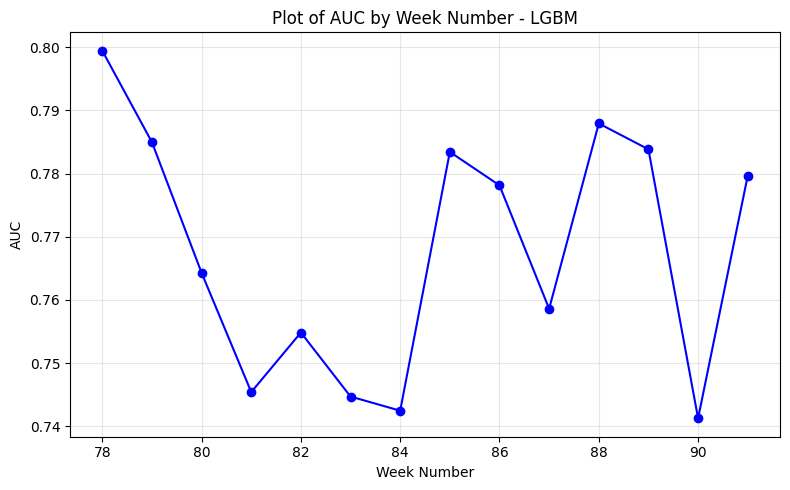

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Convert Gini to AUC: AUC = (Gini + 1) / 2
# Using list comprehension to apply the operation to each element
auc_values = [(g + 1) / 2 for g in gini_in_time_test]

# Create x-axis values (indices)
x = base_test["WEEK_NUM"].unique()

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, auc_values, 'o-', color='blue')

# Add labels and title
plt.xlabel('Week Number')
plt.ylabel('AUC')
plt.title('Plot of AUC by Week Number - LGBM')

# Add grid
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

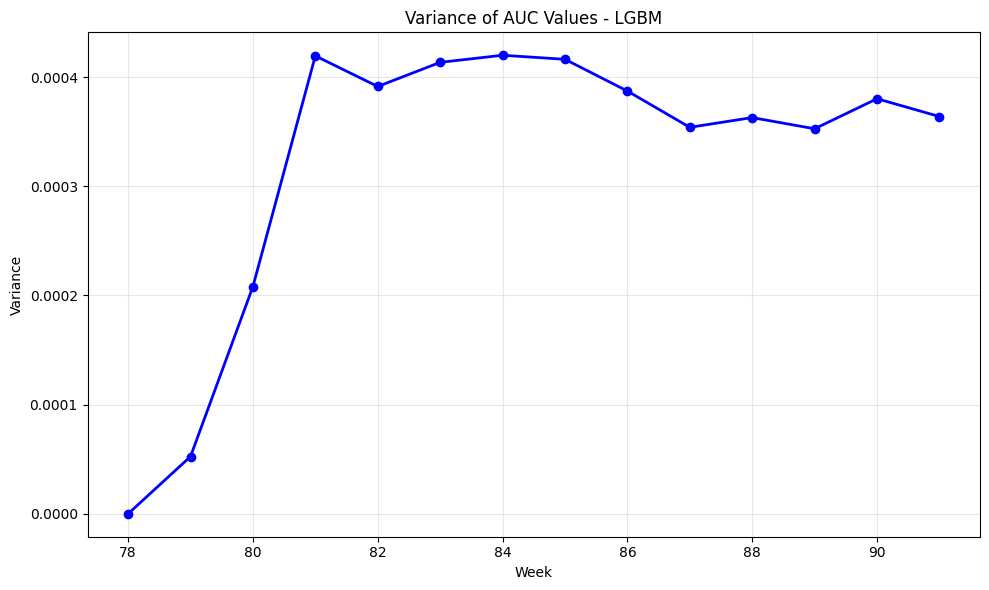

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate rolling variance (variance at each point using all previous points)
rolling_variance = []
for i in range(1, len(auc_values) + 1):
    subset = auc_values[:i]
    variance = np.var(subset)
    rolling_variance.append(variance)

# Plot the variance
plt.figure(figsize=(10, 6))
plt.plot(base_test["WEEK_NUM"].unique() , rolling_variance, 'o-', color='blue', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Variance')
plt.title('Variance of AUC Values - LGBM')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def calculate_weekly_rolling_stability(df, window_weeks, w_fallingrate=88.0, w_resstd=-0.5):
    """
    Calculate rolling stability metrics on a weekly basis.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing WEEK_NUM, target, and score columns
    window_weeks : int, default=4
        Number of weeks to include in each rolling window
    w_fallingrate : float, default=88.0
        Weight for the falling rate
    w_resstd : float, default=-0.5
        Weight for the residual standard deviation

    Returns:
    --------
    pd.DataFrame
        DataFrame with weekly stability metrics
    """
    # Get unique weeks
    unique_weeks = sorted(df['WEEK_NUM'].unique())

    # For each week starting from window_weeks, calculate stability using previous window_weeks
    results = []

    for i in range(window_weeks-1, len(unique_weeks)):
        # Get the current ending week
        end_week = unique_weeks[i]

        # Get the weeks in this window
        window_week_nums = unique_weeks[i-(window_weeks-1):i+1]

        # Filter data for these weeks
        window_data = df[df['WEEK_NUM'].isin(window_week_nums)].copy()

        # Calculate stability for this window
        gini_values, stability_score = gini_stability(window_data, w_fallingrate, w_resstd)

        results.append({
            'end_week': end_week,
            'window_weeks': window_week_nums,
            'stability_score': stability_score,
            'gini_values': gini_values,
            'avg_gini': np.mean(gini_values),
            'week_count': len(gini_values)
        })

    return pd.DataFrame(results)

def plot_weekly_stability(stability_df):
    """
    Plot the weekly stability metrics.

    Parameters:
    -----------
    stability_df : pd.DataFrame
        DataFrame with weekly stability metrics, as returned by calculate_weekly_rolling_stability
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # Plot stability score
    ax1.plot(stability_df['end_week'], stability_df['stability_score'], 'b-', marker='o')
    ax1.set_title('Weekly Stability Score - LGBM')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Stability Score')
    mean_stability = stability_df['stability_score'].mean()
    ax1.axhline(y=mean_stability, color='r', linestyle='--', label=f'Mean: {mean_stability:.2f}')
    ax1.grid(True)

    # Plot average GINI
    ax2.plot(stability_df['end_week'], stability_df['avg_gini'], 'g-', marker='o')
    ax2.set_title('Average GINI in Rolling Window - LGBM')
    ax2.set_xlabel('End Week')
    ax2.set_ylabel('Average GINI')
    ax2.grid(True)

    plt.tight_layout()
    return

In [ ]:
feature_cols = X_train.columns

combined_df_train = pd.concat([base_train, pd.DataFrame(X_train, columns=feature_cols)], axis=1)
combined_df_test = pd.concat([base_test, pd.DataFrame(X_test, columns=feature_cols)], axis=1)
combined_df_valid = pd.concat([base_valid, pd.DataFrame(X_valid, columns=feature_cols)], axis=1)

In [ ]:
# First, add an identifier column to each dataset
combined_df_train['dataset'] = 'train'
combined_df_valid['dataset'] = 'valid'
combined_df_test['dataset'] = 'test'

# Combine all three datasets into one
full_combined_df = pd.concat(
    [combined_df_train, combined_df_valid, combined_df_test],
    axis=0,          # Concatenate vertically (stack rows)
    ignore_index=False  # Keep original indices
)

<ipython-input-34-e65353afc78e>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_combined_df = pd.concat(


In [ ]:
# Calculate weekly stability with a 4-week window
stability_results = calculate_weekly_rolling_stability(base_test, window_weeks=4)

# Display results
print(stability_results[['end_week', 'stability_score', 'avg_gini']])

    end_week  stability_score  avg_gini
0         81        -2.670865  0.547038
1         82        -1.405652  0.524737
2         83        -0.368931  0.504612
3         84         0.155526  0.493703
4         85         0.499340  0.512708
5         86         0.514325  0.524355
6         87         0.515757  0.531298
7         88         0.436713  0.554028
8         89         0.544256  0.554235
9         90        -0.469498  0.535798
10        91        -0.657078  0.546326


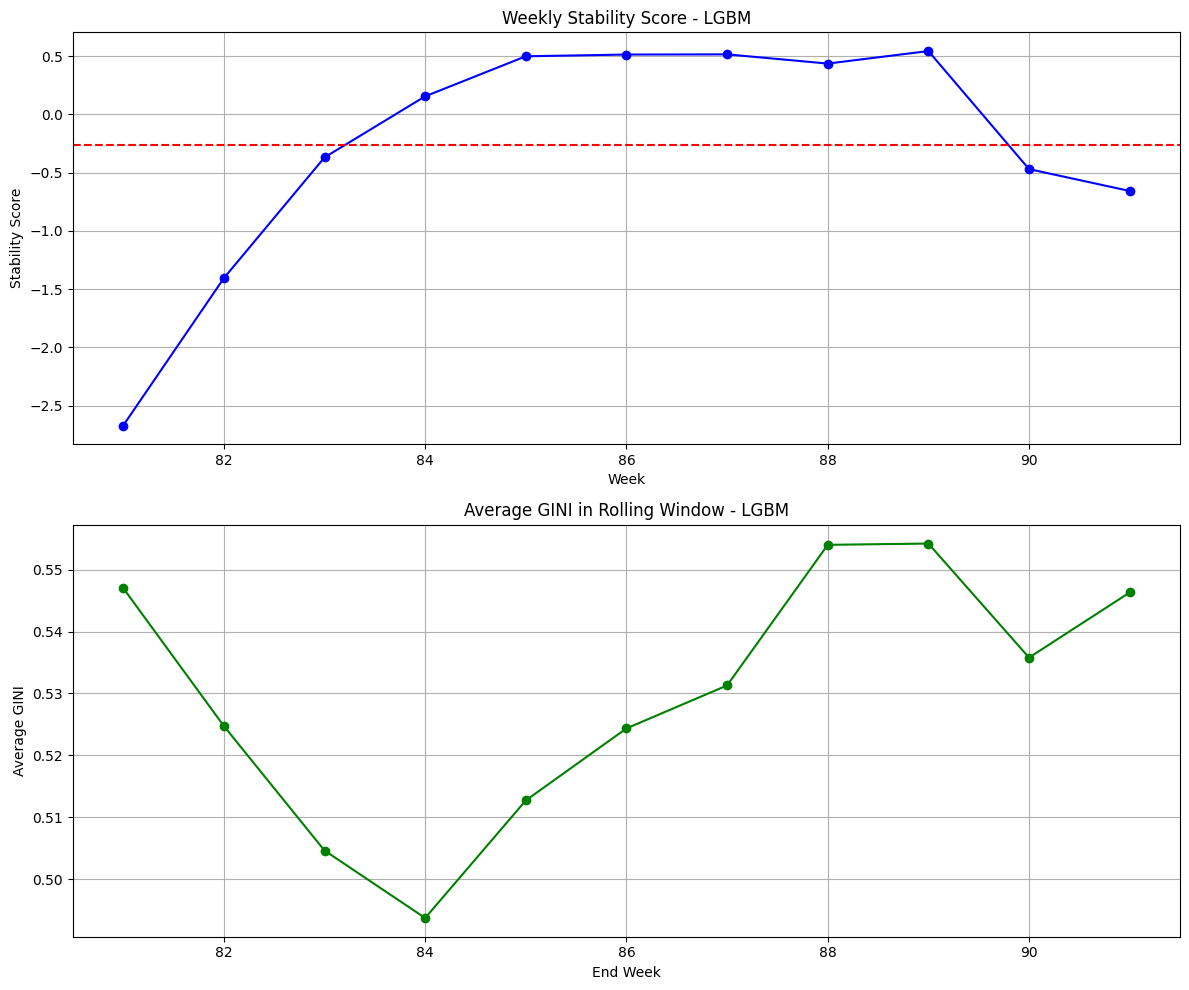

In [ ]:
plot_weekly_stability(stability_results)

In [ ]:
def plot_weekly_stability_auc(stability_df):
    """
    Plot the weekly stability metrics (stability score and GINI) on the same graph.

    Parameters:
    -----------
    stability_df : pd.DataFrame
        DataFrame with weekly stability metrics, as returned by calculate_weekly_rolling_stability
    """
    # Clear any existing plots to prevent duplicates
    plt.clf()
    plt.close('all')

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create twin y-axis for GINI
    ax2 = ax.twinx()

    # Plot stability score on primary axis
    line1, = ax.plot(stability_df['end_week'], stability_df['stability_score'], 'b-', marker='o', label='Stability Score')
    ax.set_ylabel('Stability Score', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot average GINI on secondary axis
    line2, = ax2.plot(stability_df['end_week'], (stability_df['avg_gini']+1)/2, 'g-', marker='o', label='AUC')
    ax2.set_ylabel('AUC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add mean stability line
    mean_stability = stability_df['stability_score'].mean()
    line3 = ax.axhline(y=mean_stability, color='r', linestyle='--', label=f'Mean Stability: {mean_stability:.2f}')

    # Add mean GINI line
    mean_auc = ((stability_df['avg_gini']+1)/2).mean()
    line4 = ax2.axhline(y=mean_auc, color='orange', linestyle='--', label=f'Mean AUC: {mean_auc:.2f}')

    # Set title and labels
    ax.set_title('Weekly Stability Score and AUC - LGBM')
    ax.set_xlabel('Week')
    ax.grid(True)

    # Combine legends from both axes and place it outside the plot area
    lines = [line1, line2, line3, line4]
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=4)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend at the bottom

    return

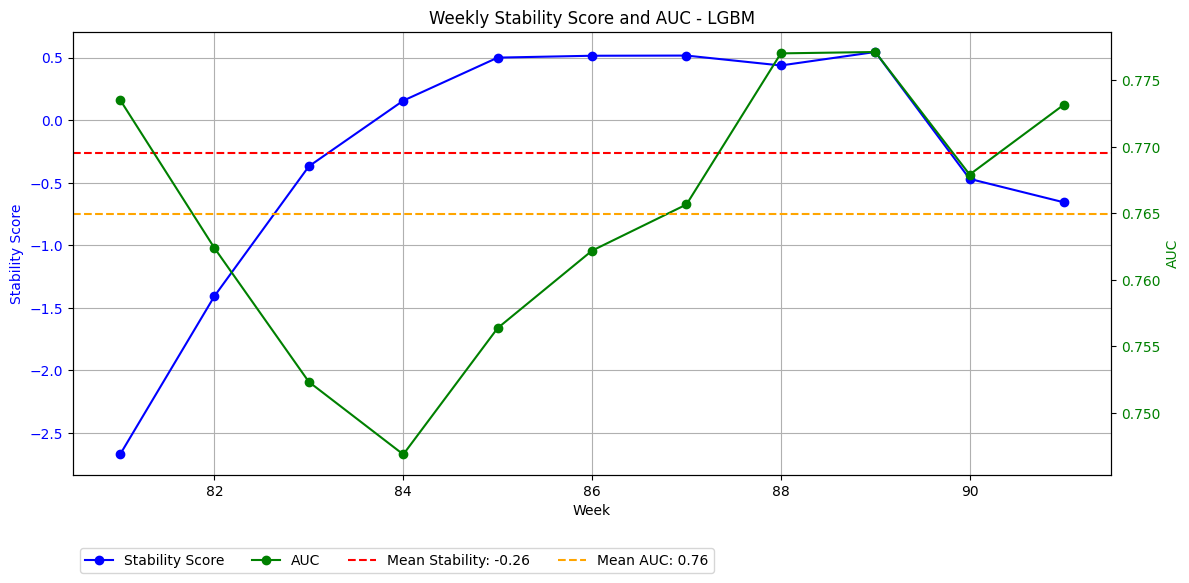

In [ ]:
plot_weekly_stability_auc(stability_results)

In [ ]:
print("AUC:", roc_auc_score(full_combined_df["target"], full_combined_df["score"]))
print("Stability:", stability_score)

AUC: 0.7913845669483976
Stability: 0.4942635512156751


In [ ]:
gini_0_65, stability_0_65 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] >= 0) & (full_combined_df['WEEK_NUM'] <= 65)])
print("AUC week 0-65:",  np.mean([(g + 1) / 2 for g in gini_0_65]))
print("Stability week 0-65:", stability_0_65)

AUC week 0-65: 0.7916719798244084
Stability week 0-65: 0.5625911694156366


In [ ]:
gini_0_60, stability_0_60 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] >= 0) & (full_combined_df['WEEK_NUM'] <= 60)])
print("AUC week 0-60:",  np.mean([(g + 1) / 2 for g in gini_0_60]))
print("Stability week 0-60:", stability_0_60)

AUC week 0-60: 0.7950377978255222
Stability week 0-60: 0.5759950666403251


In [ ]:
gini_60_65, stability_60_65 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 60) & (full_combined_df['WEEK_NUM'] <= 65)])
print("AUC week 60-65:", np.mean([(g + 1) / 2 for g in gini_60_65]))
print("Stability week 60-65:", stability_60_65)

AUC week 60-65: 0.7506090002108164
Stability week 60-65: 0.48970864159175664


In [ ]:
gini_65_70, stability_65_70 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 65) & (full_combined_df['WEEK_NUM'] <= 70)])
print("AUC week 65-70:", np.mean([(g + 1) / 2 for g in gini_65_70]))
print("Stability week 65-70:", stability_65_70)

AUC week 65-70: 0.7549492056227699
Stability week 65-70: 0.3449437982761293


In [ ]:
gini_70_91, stability_70_91 = gini_stability(full_combined_df[(full_combined_df['WEEK_NUM'] > 70) & (full_combined_df['WEEK_NUM'] <= 91)])
print("AUC week 70-91", np.mean([(g + 1) / 2 for g in gini_70_91]))
print("Stability week 70-91", stability_70_91)

AUC week 70-91 0.7655577373845
Stability week 70-91 0.5136445654779676


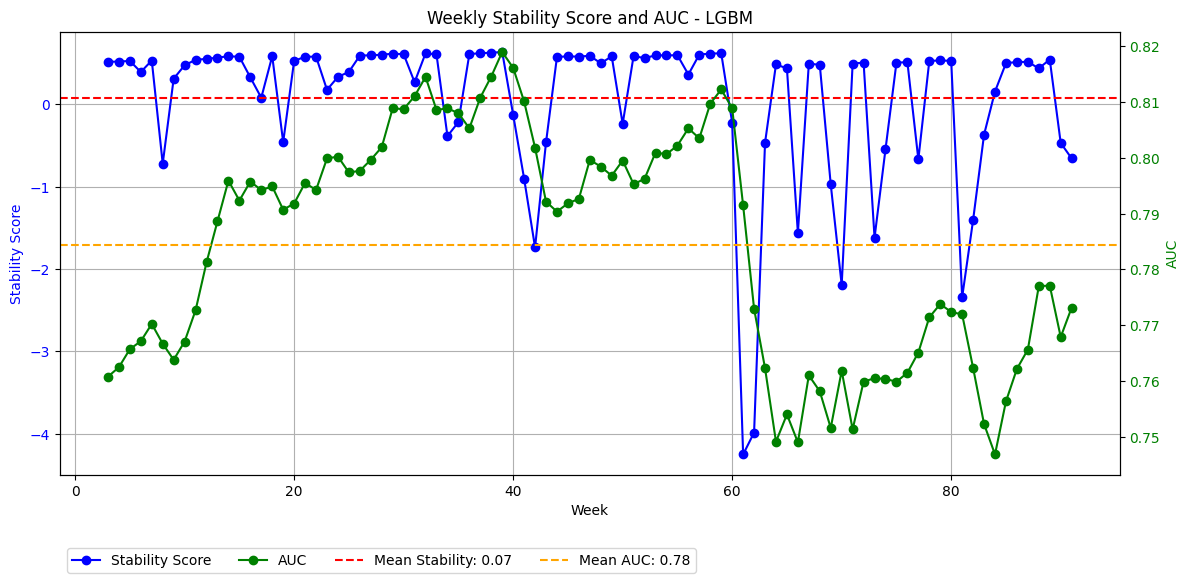

In [ ]:
stability_results_all = calculate_weekly_rolling_stability(full_combined_df, window_weeks=4)
plot_weekly_stability_auc(stability_results_all)